In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import entropy, expon, norm, probplot
from scipy.optimize import minimize
# Params
levels = 50
num_pegs = levels * (levels + 1) // 2

#Helper unctions

def angle_to_bias(theta):
    """Converts angle to bias"""
    return np.cos(theta / 2) ** 2


In [12]:
def build_galton_graph_parametrized(levels, angles):
    """Similar to the one in networkx, but with 
    variable bias distribution from Rx angles"""
    G = nx.DiGraph()
    node_id = lambda level, pos: f"{level}-{pos}"
    biases = angle_to_bias(np.array(angles))
    peg_index = 0

    for level in range(levels):
        for pos in range(level + 1):
            curr = node_id(level, pos)
            left = node_id(level + 1, pos)
            right = node_id(level + 1, pos + 1)

            if peg_index < len(biases):
                b = biases[peg_index]
            else:
                b = 0.5

            G.add_edge(curr, left, weight=1 - b)
            G.add_edge(curr, right, weight=b)
            peg_index += 1

    return G

In [13]:
def simulate_distribution(G, levels):
    start = "0-0"
    dist = {node: 0.0 for node in G.nodes()}
    dist[start] = 1.0

    for level in range(levels):
        next_dist = {node: 0.0 for node in G.nodes()}
        for node in dist:
            for succ in G.successors(node):
                next_dist[succ] += dist[node] * G[node][succ]['weight']
        dist = next_dist

    final_nodes = [n for n in dist if n.startswith(f"{levels}-")]
    probs = np.array([dist[n] for n in final_nodes])
    return probs / np.sum(probs), final_nodes


In [14]:
def target_distribution(kind, size):
    if kind == "exponential":
        x_vals = np.linspace(0, 4, size)
        ref = expon.pdf(x_vals)
    elif kind == "normal":
        x_vals = np.linspace(-3, 3, size)
        ref = norm.pdf(x_vals)
    elif kind == "hadamard":
        ref = np.zeros(size)
        ref[size//2] = 1.0
    else:
        raise ValueError("Unknown distribution type")

    return ref / np.sum(ref)

In [15]:
# statistical distance
def kl_divergence(p, q):
    p = np.clip(p, 1e-8, 1)
    q = np.clip(q, 1e-8, 1)
    return entropy(p, q)

In [16]:
def variational_cost_fn(angles, levels, target_kind):
    G = build_galton_graph_parametrized(levels, angles)
    probs, _ = simulate_distribution(G, levels)
    target = target_distribution(target_kind, len(probs))
    return kl_divergence(probs, target)

#our variational cost function

In [17]:
# post processing qaoa optimization w/ params
def optimize_qaoa_params(levels, target_kind):
    num_pegs = levels * (levels + 1) // 2
    init_angles = np.random.uniform(0, np.pi, size=num_pegs)

    result = minimize(
        variational_cost_fn,
        init_angles,
        args=(levels, target_kind),
        method="COBYLA",
        options={"maxiter": 200, "disp": True}
    )

    final_angles = result.x
    G = build_galton_graph_parametrized(levels, final_angles)
    final_probs, _ = simulate_distribution(G, levels)
    return final_probs, final_angles

In [18]:
# Prepare and compare
results = {}
for dist_kind in ["exponential", "normal", "hadamard"]:
    probs_orig, _ = simulate_distribution(
        build_galton_graph_parametrized(levels, [np.pi / 2] * num_pegs),
        levels
    )
    probs_opt, opt_angles = optimize_qaoa_params(levels, dist_kind)
    ref_dist = target_distribution(dist_kind, len(probs_opt))

    kl_orig = kl_divergence(probs_orig, ref_dist)
    kl_opt = kl_divergence(probs_opt, ref_dist)

    results[dist_kind] = {
        "original": probs_orig,
        "optimized": probs_opt,
        "reference": ref_dist,
        "kl_orig": kl_orig,
        "kl_opt": kl_opt
    }

c:\Users\13174\Documents\GaltonBoard\.pixi\envs\default\Lib\site-packages\scipy\_lib\pyprima\common\preproc.py:68: UserWarning: COBYLA: Invalid MAXFUN; it should be at least num_vars + 2; it is set to 1277
  warn(f'{solver}: Invalid MAXFUN; it should be at least {min_maxfun_str}; it is set to {maxfun}')


Return from COBYLA because the objective function has been evaluated MAXFUN times.
Number of function values = 1277   Least value of F = 0.4731918619983834
The corresponding X is:
[2.23843261 2.3881618  0.91329026 ... 0.28865913 0.40059782 0.75497662]

Return from COBYLA because the objective function has been evaluated MAXFUN times.
Number of function values = 1277   Least value of F = 0.4414329453352889
The corresponding X is:
[4.08449812 2.01017602 3.77610008 ... 2.52921974 1.91417735 0.31876593]

Return from COBYLA because the objective function has been evaluated MAXFUN times.
Number of function values = 1277   Least value of F = 4.76632692430443
The corresponding X is:
[1.93379395 1.13503961 3.01083859 ... 1.63547387 0.39216663 2.92407638]



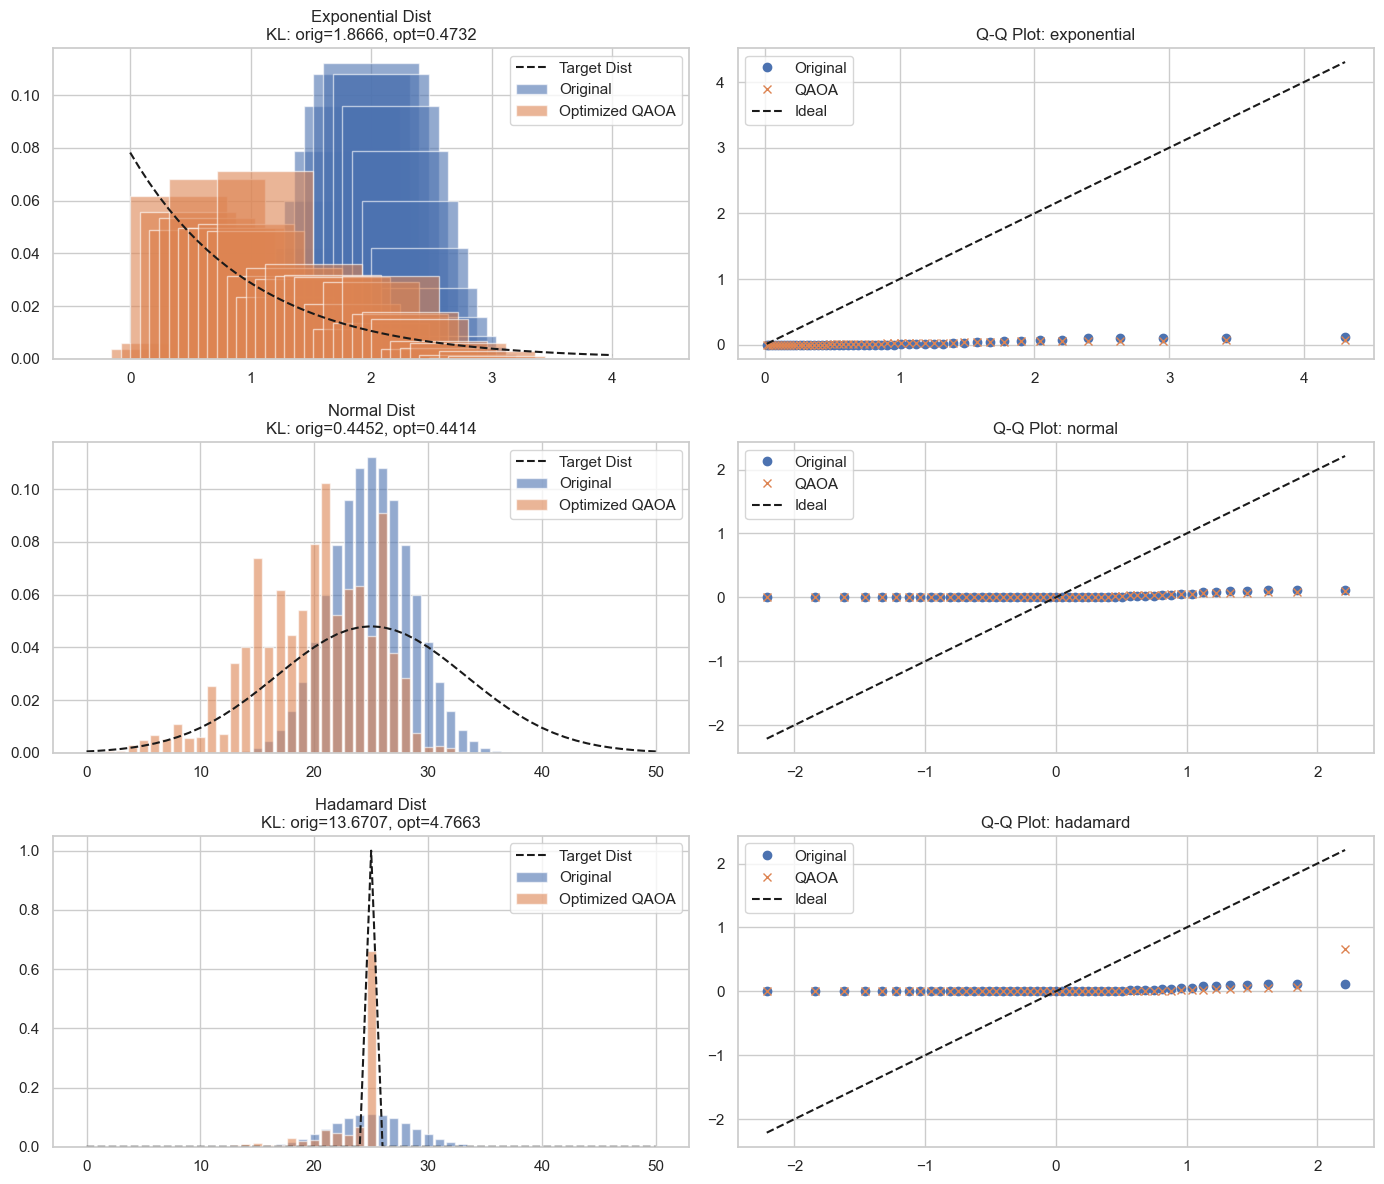

In [24]:
# Plot it

import seaborn as sns
sns.set(style="whitegrid")
import scipy.stats as stats
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2, figsize=(14, 12))
for i, dist_kind in enumerate(["exponential", "normal", "hadamard"]):
    r = results[dist_kind]
    x_vals = np.linspace(0, 4, len(r["reference"])) if dist_kind == "exponential" else np.arange(len(r["reference"]))

    probs_orig = r["original"]
    probs_opt = r["optimized"]
    target = r["reference"]
    kl_orig = r["kl_orig"]
    kl_opt = r["kl_opt"]

    bar_width = 0.8  # Overlapping style

    axs[i, 0].bar(
        x_vals,
        probs_orig,
        width=bar_width,
        alpha=0.6,
        align='center',
        label="Original"
    )
    axs[i, 0].bar(
        x_vals,
        probs_opt,
        width=bar_width,
        alpha=0.6,
        align='center',
        label="Optimized QAOA"
    )
    axs[i, 0].plot(
        x_vals,
        target,
        'k--',
        label="Target Dist"
    )
    axs[i, 0].set_title(f"{dist_kind.capitalize()} Dist\nKL: orig={kl_orig:.4f}, opt={kl_opt:.4f}")
    axs[i, 0].legend()

    # Q-Q plot
    qq_dist = "expon" if dist_kind == "exponential" else "norm"
    probplot_data_orig = probplot(probs_orig, dist=qq_dist, fit=False)
    probplot_data_opt = probplot(probs_opt, dist=qq_dist, fit=False)

    axs[i][1].plot(probplot_data_orig[0], probplot_data_orig[1], 'o', label="Original")
    axs[i][1].plot(probplot_data_opt[0], probplot_data_opt[1], 'x', label="QAOA")
    axs[i][1].plot(probplot_data_orig[0], probplot_data_orig[0], 'k--', label="Ideal")
    axs[i][1].set_title(f"Q-Q Plot: {dist_kind}")
    axs[i][1].legend()

plt.tight_layout()
plt.show()
